In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
#from kneed import KneeLocator
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from os import listdir
from os.path import isfile, join
import os
import datetime as dt
import scipy.io
import glob
import pyresample
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import netCDF4
import datetime as dt
from netCDF4 import date2num,num2date

import matplotlib.colors as colors
import matplotlib as mpl
from netCDF4 import Dataset
import IPython.display
import cmocean
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.dates as mdates
import plotly.express as px
from matplotlib.ticker import NullFormatter
from matplotlib import rc
#import cosima_cookbook as cc
#from mpl_toolkits.basemap import Basemap
import math
import time
import sys

def get_var_list(list_name):
    '''
    Get a list of variables associated with a pre-defined name.
    '''
    if list_name == 'ocn':
        var_list = ['sst','sss','uocn','vocn','frzmlt']
    elif list_name == 'atmo':
        var_list = ['Tair','uatm','vatm','fswdn','flwdn','snow']
    elif list_name == 'wave':
        var_list = ['aice','wave_sig_ht','peak_period','mean_wave_dir']
    elif list_name == 'ice':
        var_list = ['aice','hi','fsdrad','iage','uvel','vvel','frazil','congel']
    elif list_name == 'JRA55':
            var_list = ['airtmp']
    elif list_name == 'static':
#        var_list = ['aice','hi','hs','fsdrad','sice','iage','vlvl','vrdg']
        var_list = ['aice','hi','hs','fsdrad','iage','alvl']
    else:
        var_list = [list_name]

    return var_list

def ProgressBar(Total, Progress, BarLength=20, ProgressIcon="#", BarIcon="-"):
    try:
        # You can't have a progress bar with zero or negative length.
        if BarLength <1:
            BarLength = 20
        # Use status variable for going to the next line after progress completion.
        Status = ""
        # Calcuting progress between 0 and 1 for percentage.
        Progress = float(Progress) / float(Total)
        # Doing this conditions at final progressing.
        if Progress >= 1.:
            Progress = 1
            Status = "\r\n"    # Going to the next line
        # Calculating how many places should be filled
        Block = int(round(BarLength * Progress))
        # Show this
        Bar = "[{}] {:.0f}% {}".format(ProgressIcon * Block + BarIcon * (BarLength - Block), round(Progress * 100, 0), Status)
        return Bar
    except:
        return "ERROR"


def ShowBar(Bar):
    sys.stdout.write(Bar)
    sys.stdout.flush()
    
#del length

In [31]:
# Read in the CICE data
var_name = 'static'
variable_list = get_var_list(var_name)
num_variables = np.size(variable_list)

# '/Users/noahday/Gadi/ia40/waves-10/history/iceh.2002-08-26.nc' 
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
savepath = '/home/566/nd0349/notebooks/'

os.chdir(mypath)
file_dates = []
year_range = range(2010,2015)

#X_out_all = np.ma.masked_array(np.empty((size,1)), mask=mask)

# Loop over a couple years
for year in year_range:
#    year = '2005'
    print(year)
    filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'

    onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
    onlyfiles.sort()

    ds = xr.open_dataset(filename)
    LN = ds.TLON.values
    LT = ds.TLAT.values
    # Get the total number of grid points
    size = 1
    for dim in np.shape(LN): size *= dim
    aice_data = ds['aice'][0,:,:]
    mask1 = np.ma.masked_where(LT > 0.0, aice_data)
    mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
    master_mask = mask1.mask | mask2.mask
    mask = master_mask

    X_out =  np.ma.masked_array(np.empty((size,1)), mask=mask)
    
    # Loop over the files in that year
    for filecount, file in enumerate(onlyfiles):
        progressBar = "\rProgress: " + ProgressBar(len(onlyfiles), filecount+1, 20, '#', '.')
        ShowBar(progressBar)
        
        # Open the file
        filename = file
        file_dates.append(np.datetime64(file[-13:-3]))
        ds = xr.open_dataset(filename)
        
        # Get and apply masks to remove the ocean
        aice_data = ds['aice'][0,:,:]
        mask1 = np.ma.masked_where(LT > 0.0, aice_data)
        mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
        master_mask = mask1.mask | mask2.mask
        mask = master_mask
        
        # Get all the variables
        for counter, exp in enumerate(variable_list):
            data = ds[exp][0,:,:]
            data_masked = np.ma.masked_where(mask, data.values)
            data_masked_vec = data_masked.compressed()
            row_length, = data_masked_vec.shape

            if counter == 0: 
                # First file, then initialise X_temp
                X_single_file = data_masked_vec.reshape(row_length,1)
            else:
                # Else just concatenate the new data on
                X_single_file = np.concatenate([X_single_file, data_masked_vec.reshape(row_length,1)],axis=1)

        # Add on the corresponding coordinates
        LN_masked = np.ma.masked_where(mask, LN)
        LN_vec = LN_masked.compressed()
        LT_masked = np.ma.masked_where(mask, LT)
        LT_vec = LT_masked.compressed()
        X_single_file = np.concatenate([X_single_file, LN_vec.reshape(row_length,1), LT_vec.reshape(row_length,1)],axis=1)
        
        if filecount == 0: 
            # Day 1, then initialise the year file
            X_year = X_single_file
            datetime_vec =  np.tile(np.datetime64(file[-13:-3]),(row_length,1))
        else:
            X_year = np.concatenate([X_year, X_single_file],axis=0)
            datetime_vec = np.concatenate([datetime_vec, np.tile(np.datetime64(file[-13:-3]),(size,1))],axis=0)
        
    if year == year_range[0]:
        # Year 1, then initialise the full dataset
        X_total = X_year
        datetime_vec_all = datetime_vec
    else:
        X_total = np.concatenate([X_total, X_year], axis=0)
        datetime_vec_all = np.concatenate([datetime_vec_all, datetime_vec],axis=0)
        

        
df_raw = pd.DataFrame(X_total, columns = variable_list+['longitude','latitude'])#,'date'])
df_raw['date'] = datetime_vec_all
df_raw = df_raw.dropna()

# Print the dataset

df_raw.describe()

2010
Progress: [####################] 100% 
2011
Progress: [####################] 100% 
2012
Progress: [####################] 100% 
2013
Progress: [####################] 100% 
2014
Progress: [####################] 100% 


ValueError: Length of values (196752399) does not match length of index (34230389)

In [29]:
#df_raw['date'].unique()
#len(onlyfiles)
#year_range = range(2005,2012)
#year_range[0]
print(X_out.shape)
print(X_temp.shape)

(108000, 1)
(17378, 8)


Text(0.5, 1.0, 'Log-Min/Max')

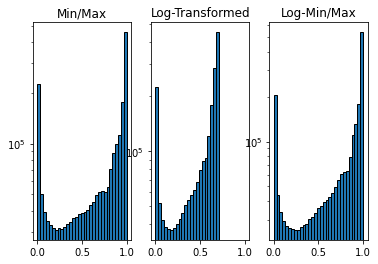

In [5]:
# Standardisation
X_train = df_raw['fsdrad'].values
len_X, = X_train.shape

min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train.reshape(len_X,1))

#create log-transformed data
X_log = np.log(X_train_minmax+1)
scaler = StandardScaler()
#scaled_features = scaler.fit_transform(X_standardized)

X_log_minmax = min_max_scaler.fit_transform(X_log.reshape(len_X,1))


#define grid of plots

fig, axs = plt.subplots(nrows=1, ncols=3)

#create histograms

axs[0].hist(X_train_minmax, edgecolor='black',bins=31,log=True,range=[0, 1])
axs[1].hist(X_log, edgecolor='black',bins=31,log=True,range=[0, 1])
axs[2].hist(X_log_minmax, edgecolor='black',bins=31,log=True,range=[0, 1])


#add title to each histogram
axs[0].set_title('Min/Max')
axs[1].set_title('Log-Transformed')
axs[2].set_title('Log-Min/Max')
    


In [3]:
# Standardise all the variables

X_temp = df_raw['aice'].values
len_X, = X_temp.shape
row_index = len_X
X_train = np.zeros((row_index,1))
for counter, exp in enumerate(variable_list):
    X_temp_vec = df_raw[exp].values

    min_max_scaler = preprocessing.MinMaxScaler()
    X_temp_vec = min_max_scaler.fit_transform(X_temp_vec.reshape(row_index,1))

    # Log transformation
#    X_temp_vec = np.log(X_temp_vec+1)
   # scaler = StandardScaler()
    X_temp_vec = min_max_scaler.fit_transform(X_temp_vec.reshape(row_index,1))
    X_train = np.concatenate([X_train, X_temp_vec],axis=1)

temp_lon = df_raw['longitude'].to_numpy()
temp_lat = df_raw['latitude'].to_numpy()
X_train = np.concatenate([X_train, temp_lon.reshape(row_index,1), temp_lat.reshape(row_index,1)],axis=1)
X_train=np.delete(X_train,0,1)

df_standard = pd.DataFrame(X_train, columns = variable_list+['longitude','latitude'])
#df_standard['date'] = df_raw['date']#np.datetime64(file_date)
df_standard['date'] = df_raw['date'].values


print(df_standard.describe())
df_standard

print(df_standard['date'])



               aice            hi            hs        fsdrad          iage  \
count  2.152250e+06  2.152250e+06  2.152250e+06  2.152250e+06  2.152250e+06   
mean   9.270119e-01  1.779155e-01  1.509065e-01  5.997365e-01  1.473606e-01   
std    1.714298e-01  1.074228e-01  1.271780e-01  3.646778e-01  1.188648e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    9.551381e-01  9.245431e-02  4.635987e-02  2.536250e-01  5.564869e-02   
50%    9.964472e-01  1.714348e-01  1.179377e-01  7.003244e-01  1.142344e-01   
75%    9.994671e-01  2.501367e-01  2.318676e-01  9.515471e-01  2.069404e-01   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

               alvl     longitude      latitude  
count  2.152250e+06  2.152250e+06  2.152250e+06  
mean   7.326024e-01  2.073151e+02 -6.852023e+01  
std    2.238698e-01  1.001829e+02  5.137084e+00  
min    0.000000e+00  5.000000e-01 -7.762990e+01  
25%    6.173517e-01  1.555000e+02 -7.2

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


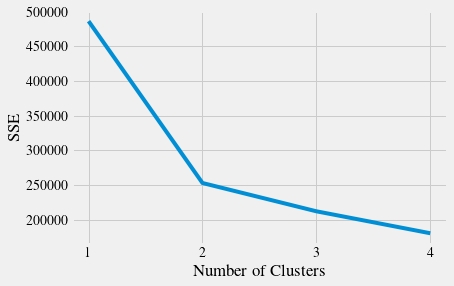

<Figure size 432x288 with 0 Axes>

In [192]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)
#print(df_standard.iloc[:, 3] )
del X_train
X_train = df_standard.iloc[:, 0:-3] 
X_train
kmeans.fit(X_train)

# The lowest SSE value
kmeans.inertia_

# Final locations of the centroid
kmeans.cluster_centers_

# The number of iterations required to converge
kmeans.n_iter_
kmeans.labels_[:5]


kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 5), sse)
plt.xticks(range(1, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
plt.savefig(savepath+'SSE.png', dpi = 300)  



In [ ]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train)
    score = silhouette_score(X_train, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 5), silhouette_coefficients)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()
plt.savefig(savepath+'silhouette.png', dpi = 300)  

In [7]:
# Initial centroid
#0.0123    0.0054    0.0009    0.0077    0.0139    0.0075    0.0013    0.0048
#0.9825    0.4804    0.2950    0.9470    0.5100    0.2033    0.3641    0.3532
#0.9432    0.1913    0.0802    0.7402    0.6518    0.0914    0.2116    0.0867

init_centroids = np.array([[0.223, 0.0054, 0.0009, 0.0007, 0.0139, 0.0075, 0.0013, 0.0048], 
                           [0.9825, 0.4804, 0.2950, 0.9470, 0.5100, 0.2033, 0.3641, 0.3532], 
                           [0.9432, 0.1913, 0.0802, 0.7402, 0.6518, 0.0914, 0.2116, 0.0867]])

init_centroids2 = np.array([[0.96221878, 0.08398237, 0.06508808, 0.04646253, 0.3788989,  0.05517018, 0.21942225], 
                            [0.95768088, 0.29923383, 0.24225471, 0.21369082, 0.13641108, 0.1632028,  0.31585801], 
                            [0.95627117, 0.2773644,  0.18689209, 0.84940695, 0.17923583, 0.17167591, 0.46987752]])
                          # [0.33422491, 0.11073472, 0.04112143, 0.17990378, 0.19245547, 0.22089278,  0.06789923]

init_centroids3 = np.array([[0.88114293, 0.07834562, 0.06959487, 0.15402359, 0.25723424, 0.08001789, 0.15786113], 
                            [0.9762807,  0.21524319, 0.15204812, 0.93874533, 0.1757047,  0.11999053, 0.44372855],
                            [0.93300114, 0.25759262, 0.26726858, 0.68848653, 0.101471,   0.18438339, 0.24430108]])

init_centroids_6 = np.array([[0.96221878, 0.08398237, 0.06508808, 0.04646253,  0.05517018, 0.21942225], 
                            [0.95768088, 0.29923383, 0.24225471, 0.21369082, 0.1632028,  0.31585801], 
                            [0.95627117, 0.2773644,  0.18689209, 0.84940695, 0.17167591, 0.46987752]])

init_centroids_good = np.array([[0.76306007, 0.04041951, 0.02538844, 0.02783396, 0.05290037, 0.74416677],
                                [0.96479608, 0.11019326, 0.10738233, 0.26478933, 0.07206991, 0.80610988],
                                [0.96413898, 0.18858583, 0.14985236, 0.82837526, 0.10536767, 0.74644532]])
# [0.77589729 0.05923769 0.03718766 0.03286393 0.07182331 0.74087688] 
# [0.98582395 0.09821617 0.09138259 0.21849372 0.0681823  0.89251486]
# [0.95809312 0.22422081 0.17665379 0.78734598 0.11919958 0.73010699]

kmeans = KMeans(
    init="random",
    # init=init_centroids_good,
    n_clusters=3,
    n_init=10, #10,
    max_iter=300,
    random_state=2020
)
year = 2019
df_standard = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+str(year)+'.csv')
#print(df_standard)
df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+str(year)+'.csv')
# Take a sub-sample (same number of points for each date)
#df_temp = df_standard
df_temp = df_standard.drop(df_raw[df_raw.aice < 0.01].index)
#df_subsample = df_temp.groupby('date', group_keys=False).apply(lambda x: x.sample(500))
#df_subsample = df_temp
#X_train = df_subsample.iloc[:, 0:6] 
X_train = df_standard.iloc[:, [4]] 
print(X_train)
kmeans.fit(X_train)
#kmeans.cluster_centers_ = init_centroids_good

#X_all = df_standard.iloc[:, 1:7] 
predicted = kmeans.predict(X_train) 

df_kmeans = df_standard
df_kmeans['k'] = predicted # kmeans.labels_

print(kmeans.cluster_centers_)
#df_kmeans.to_csv('kmeans.csv', index=False)
#df_kmeans.groupby('k').describe()

           fsdrad
0        0.999902
1        0.999745
2        0.999617
3        0.999551
4        0.999563
...           ...
2104607  0.002373
2104608  0.002373
2104609  0.002373
2104610  0.002373
2104611  0.002373

[2104612 rows x 1 columns]
[[0.54242076]
 [0.9140643 ]
 [0.09683999]]


/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2000-01-01.nc


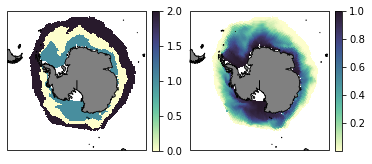

In [8]:
filename = '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2000-01-01.nc'
savepath = '/g/data/ia40/'
print(filename)
ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values

#print(ds['k'].shape)
#k_means_plot = df_kmeans['k']
#fsdrad_plot = df_kmeans['fsdrad'][:,:]

selected_date = '2019-08-15'
date_idx = df_kmeans['date'] == selected_date

lon = df_kmeans['longitude'][date_idx];
lat = df_kmeans['latitude'][date_idx];
k = df_kmeans['k'][date_idx];
ra = df_kmeans['fsdrad'][date_idx];

row_length = date_idx.sum()
lon = lon.values.reshape(row_length,1)
lat = lat.values.reshape(row_length,1)
k = k.values.reshape(row_length,1)
ra = ra.values.reshape(row_length,1)

k_means_array = np.empty(LN.shape)
k_means_array[:] = np.nan

fsdrad_array = np.empty(LN.shape)
fsdrad_array[:] = np.nan

lats = LT
lons = LN

for row_lp in range(0, row_length):
    a = abs(lats-lat[row_lp])+abs(lons-lon[row_lp])
    i,j = np.unravel_index(a.argmin(),a.shape)
    k_means_array[i,j] = k[row_lp]
    fsdrad_array[i,j] = ra[row_lp]


fontprops = fm.FontProperties(size=18)
plt.figure()
cmap = cmo.deep
coord_lims = [-180, 180, -50, -90]

ax = plt.subplot(1, 2, 0+1, projection=ccrs.SouthPolarStereo())
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(LN, LT, k_means_array,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)
#gl = ax.gridlines(draw_labels=False)
#scalebar = AnchoredSizeBar(ax.transData,
#                           100000, '100 km', 'lower center', 
#                           pad=0.1,
#                           color='black',
#                           frameon=False,
#                           size_vertical=1,
#                           fontproperties=fontprops)
#
#ax.add_artist(scalebar)
#plt.savefig('kmean.png', dpi = 300)  

ax = plt.subplot(1, 2, 0+2, projection=ccrs.SouthPolarStereo())
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(LN, LT, fsdrad_array,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)
#scalebar = AnchoredSizeBar(ax.transData,
#                           100000, '100 km', 'lower center', 
#                           pad=0.1,
#                           color='black',
#                           frameon=False,
#                           size_vertical=1,
#                           fontproperties=fontprops)
#ax.add_artist(scalebar)
#plt.savefig(savepath+'kmean_and_fsdrad_'+selected_date+'.png', dpi = 300)  



In [89]:
hte = ds.HTE.values
k_means_array == 1
#print(hte.shape)
#print(k_means_array.shape)
np.sum(hte[k_means_array == 1])
#print(k_means_array[:,180] == 1)
miz_width_array = np.zeros((365,360))
#print(miz_width_array[day_idx,:])
#miz_width_array = np.na
#day_vec = range(0,n_days,1)

# Circumpolar for each day
#for day_idx in day_vec:
#    progressBar = "\rProgress: " + ProgressBar(n_days, day_idx+1, 20, '#', '.')
#    ShowBar(progressBar)


n_lon = 360
day_idx = 1
miz_cluster = 1
for lon_idx in range(0,n_lon):
    # MIZ width
#    print(lon_idx)
    miz_idx = k_means_array[:,lon_idx] == miz_cluster
#    print(k_means_array[:,lon_idx].data)
#    print(miz_idx)
#    sic_idx = ds['aice'][day_idx,:,lon_idx].data > 0.15
#    miz_idx = miz_idx#*miz_idx
#    sic_1580_idx = np.logical_and(sic_idx,ds['aice'][day_idx,:,lon_idx].data < 0.8)
    if not any(miz_idx):
        # If there are no MIZ cells then set distance to 0
        miz_width_array[day_idx,lon_idx] = np.nan
       # print(miz_idx)
#        effective_miz_width_array[day_idx,lon_idx] = 0


#        miz_upper_boundary[day_idx,lon_idx] = LT[0,lon_idx]
#        miz_lower_boundary[day_idx,lon_idx] = LT[0,lon_idx]
    else:
        miz_width_array[day_idx,lon_idx] = ds['HTE'][miz_idx,lon_idx].data.sum()
        #print(miz_idx)
       # print(ds['HTE'][miz_idx,lon_idx].data.sum())
 #       effective_miz_width_array[day_idx,lon_idx] = np.multiply(ds['HTE'][miz_idx,lon_idx].data, ds['aice'][day_idx,miz_idx,lon_idx].data).sum()

print(np.nanmean(miz_width_array[day_idx,:])/1000)
print(miz_width_array[day_idx,:])

133.4583847777562
[           nan  85932.6328125  85932.6328125  85932.6328125
            nan            nan            nan  84350.8515625
  84350.8515625  84350.8515625  84350.8515625  84350.8515625
  84350.8515625  84350.8515625            nan            nan
  82744.046875   82744.046875   82744.046875   81114.8828125
  81114.8828125  81114.8828125  81114.8828125  79466.09375
  79466.09375    79466.09375    79466.09375    79466.09375
  79466.09375    79466.09375    79466.09375   157266.5
 157266.5       157266.5       157266.5       157266.5
  77800.3984375  77800.3984375  77800.3984375  77800.3984375
  77800.3984375  77800.3984375  76120.59375    76120.59375
  76120.59375    76120.59375    76120.59375    76120.59375
  76120.59375    76120.59375    76120.59375    76120.59375
  76120.59375    76120.59375    76120.59375    76120.59375
  76120.59375    76120.59375    76120.59375    76120.59375
  76120.59375    76120.59375    76120.59375    76120.59375
  76120.59375   153921.        153

In [84]:
k_means_array[:,lon_idx-20]
miz_idx
k_means_array[:,lon_idx] == miz_cluster
k_means_array.shape

(300, 360)

In [15]:
unique_dates = df_kmeans['date'].unique()
tmp1, = unique_dates.shape

tmp2, tmp3 = LN.shape
k_means_array = np.empty((tmp1,tmp2,tmp3))
k_means_array[:] = np.nan

date_length, = unique_dates.shape

for time_lp, date_tmp in enumerate(unique_dates):
    progressBar = "\rProgress: " + ProgressBar(date_length, time_lp+1, 20, '#', '.')
    ShowBar(progressBar)
    date_idx = df_kmeans['date'] == date_tmp

    lon = df_kmeans['longitude'][date_idx];
    lat = df_kmeans['latitude'][date_idx];
    k = df_kmeans['k'][date_idx];

    row_length = date_idx.sum()
    lon = lon.values.reshape(row_length,1)
    lat = lat.values.reshape(row_length,1)
    k = k.values.reshape(row_length,1)
    for row_lp in range(0, row_length):
        a = abs(LT-lat[row_lp])+abs(LN-lon[row_lp])
        i,j = np.unravel_index(a.argmin(),a.shape)
        k_means_array[time_lp,i,j] = k[row_lp]

Progress: [####################] 100% 


In [16]:
unique_dates = df_kmeans['date'].unique()
tmp1, = unique_dates.shape
tmp2, tmp3 = LN.shape
# Training variables for k-means
aice_array = np.empty((tmp1,tmp2,tmp3))
hi_array = np.empty((tmp1,tmp2,tmp3))
hs_array = np.empty((tmp1,tmp2,tmp3))
fsdrad_array = np.empty((tmp1,tmp2,tmp3))
#sice_array = np.empty((tmp1,tmp2,tmp3))
iage_array = np.empty((tmp1,tmp2,tmp3))
#vlvl_array = np.empty((tmp1,tmp2,tmp3))
alvl_array = np.empty((tmp1,tmp2,tmp3))

# Extra variables of interest
swh_array = np.empty((tmp1,tmp2,tmp3))
ppd_array = np.empty((tmp1,tmp2,tmp3))


date_length, = unique_dates.shape

for filecount, file in enumerate(onlyfiles):
    filename = file
    progressBar = "\rProgress: " + ProgressBar(date_length, filecount+1, 20, '#', '.')
    ShowBar(progressBar)

    ds = xr.open_dataset(filename)
    LN = ds.TLON.values
    LT = ds.TLAT.values

    aice_data = ds['aice'][0,:,:]

    mask1 = np.ma.masked_where(LT > 0.0, aice_data)
    mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
    master_mask = mask1.mask | mask2.mask
    mask = master_mask

    data = ds['aice'][0,:,:]
    aice_array[filecount,:,:] = data
    aice_array[filecount,mask] = np.nan
    
    data = ds['hi'][0,:,:]
    hi_array[filecount,:,:] = data
    hi_array[filecount,mask] = np.nan
    
    data = ds['hs'][0,:,:]
    hs_array[filecount,:,:] = data
    hs_array[filecount,mask] = np.nan
    
    data = ds['fsdrad'][0,:,:]
    fsdrad_array[filecount,:,:] = data
    fsdrad_array[filecount,mask] = np.nan
    
#    data = ds['sice'][0,:,:]
#    sice_array[filecount,:,:] = data
#    sice_array[filecount,mask] = np.nan
    
    data = ds['iage'][0,:,:]
    iage_array[filecount,:,:] = data
    iage_array[filecount,mask] = np.nan
    
    #data = ds['vlvl'][0,:,:]
    #vlvl_array[filecount,:,:] = data
    #vlvl_array[filecount,mask] = np.nan
    data = ds['alvl'][0,:,:]
    alvl_array[filecount,:,:] = data
    alvl_array[filecount,mask] = np.nan
    
    # Extra variables of interest
    data = ds['wave_sig_ht'][0,:,:]
    swh_array[filecount,:,:] = data
    swh_array[filecount,mask] = np.nan
    
    data = ds['peak_period'][0,:,:]
    ppd_array[filecount,:,:] = data
    ppd_array[filecount,mask] = np.nan

Progress: [####################] 100% 


In [ ]:
#onlyfiles[0]
#unique_dates = df_kmeans['date'].unique()
#tmp1, = unique_dates.shape
#tmp2, tmp3 = LN.shape
#aice_array = np.empty((tmp1,tmp2,tmp3))
#aice_array[:] = np.nan

#aice_array.shape()
#aice_array.shape
#aice_array[filecount,:,:] = aice_data
#aice_array[filecount,mask] = np.nan
#aice_array[filecount,:,:]

In [17]:
#filename=f"/home/566/nd0349/kmeans_{year:s}.nc"
# HTE, HTN, tarea, tmask
ds = xr.open_dataset(onlyfiles[0])
HTE = ds.HTE.values
HTN = ds.HTN.values
tarea = ds.tarea.values
tmask = ds.tmask.values

filename=f"/g/data/ia40/kmeans_2016_3clusters.nc"
d_vars = {"k" : (['time','nj','ni'],k_means_array,
                              {'long_name' :"k-means_clusters",
                               'units'     :"cluster number",
                               '_FillValue':-2e8}),
          "aice" : (['time','nj','ni'],aice_array,
                              {'long_name' :"Areal sea ice area proportion of cell",
                               'units'     :"-",
                               '_FillValue':-2e8}),
          "hi" : (['time','nj','ni'],hi_array,
                              {'long_name' :"Grid cell mean ice thickness",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "hs" : (['time','nj','ni'],hs_array,
                              {'long_name' :"Grid cell mean snow thickness",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "fsdrad" : (['time','nj','ni'],fsdrad_array,
                              {'long_name' :"Representative floe radius",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "iage" : (['time','nj','ni'],iage_array,
                              {'long_name' :"Sea ice age",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "alvl" : (['time','nj','ni'],alvl_array,
                              {'long_name' :"Level ice area fraction",
                               'units'     :"-",
                               '_FillValue':-2e8}),
          "wave_sig_ht" : (['time','nj','ni'],swh_array,
                              {'long_name' :"Signficant wave height",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "HTE" : (['nj','ni'],HTE,
                          {'long_name':"T cell width on East side",
                           'units'    :"m",
                           '_FillValue':-2e8}),
          "HTN" : (['nj','ni'],HTN,
                          {'long_name':"T cell width on North side",
                           'units'    :"m",
                           '_FillValue':-2e8}),
          "tarea" : (['nj','ni'],tarea,
                          {'long_name':"area of T grid cells",
                           'units'    :"m^2",
                           '_FillValue':-2e8}),
          "tmask" : (['nj','ni'],tmask,
                          {'long_name':"ocean grid mask",
                           'units'    :"Boolean",
                           '_FillValue':-2e8})}
          
coords = {"LON"  : (["nj","ni"],LN,{'units':'degrees_east'}),
          "LAT"  : (["nj","ni"],LT,{'units':'degrees_north'}),
          "time" : (["time"],unique_dates)}
attrs = {'creation_date': "2023-04-07",#datetime.now().strftime('%Y-%m-%d %H'),
         'conventions'  : "",
         'title'        : "k-means clusters for CICE-WIM standalone 1-degree data",
         'source'       : ", ",
         'comment'      : "",
         'author'       : 'Noah Day',
         'email'        : 'noah.day@adelaide.edu.au'}
enc_dict  = {'shuffle':True,'zlib':True,'complevel':5} 
nc_out = xr.Dataset(data_vars=d_vars,coords=coords,attrs=attrs)
write_job = nc_out.to_netcdf(filename,unlimited_dims=['time'],compute=False)#,encoding={'glbrad':enc_dict})

#nc_out.close(); print('Dataset is closed!')

## Comparison with Brouwer et al. (2022)


In [18]:
# Calculate MIZ width
ds = xr.open_dataset(filename)
n_days, n_lat, n_lon = ds['k'].shape
miz_cluster = 0 # What cluster does the MIZ correspond with?

# Initialise arrays
miz_width_array = np.empty((n_days,n_lon))
effective_miz_width_array = np.empty((n_days,n_lon))
sic_width_array = np.empty((n_days,n_lon))

miz_upper_boundary = np.empty((n_days,n_lon))
miz_lower_boundary = np.empty((n_days,n_lon))


day_vec = range(0,n_days,1)

# Circumpolar for each day
for day_idx in day_vec:
    progressBar = "\rProgress: " + ProgressBar(n_days, day_idx+1, 20, '#', '.')
    ShowBar(progressBar)
    for lon_idx in range(0,n_lon):
        # MIZ width
        miz_idx = ds['k'][day_idx,:,lon_idx].data == miz_cluster
        sic_idx = ds['aice'][day_idx,:,lon_idx].data > 0.15
        miz_idx = miz_idx*sic_idx
        sic_1580_idx = np.logical_and(sic_idx,ds['aice'][day_idx,:,lon_idx].data < 0.8)
        if not any(miz_idx):
            # If there are no MIZ cells then set distance to 0
            miz_width_array[day_idx,lon_idx] = 0
            effective_miz_width_array[day_idx,lon_idx] = 0
            
            
            miz_upper_boundary[day_idx,lon_idx] = LT[0,lon_idx]
            miz_lower_boundary[day_idx,lon_idx] = LT[0,lon_idx]
        else:
            miz_width_array[day_idx,lon_idx] = ds['HTE'][miz_idx,lon_idx].data.sum()
            effective_miz_width_array[day_idx,lon_idx] = np.multiply(ds['HTE'][miz_idx,lon_idx].data, ds['aice'][day_idx,miz_idx,lon_idx].data).sum()
            
            locs = np.asarray(miz_idx).nonzero()
            miz_upper_boundary[day_idx,lon_idx] = LT[locs[0][-1],lon_idx]
            miz_lower_boundary[day_idx,lon_idx] = LT[locs[0][0],lon_idx]
            
        if not any(sic_1580_idx):
            sic_width_array[day_idx,lon_idx] = 0
        else:
            sic_width_array[day_idx,lon_idx] = ds['HTE'][sic_1580_idx,lon_idx].data.sum()


Progress: [####################] 100% 


In [64]:
print(LN.shape)
print(ds['HTE'].shape)
LN[1,:]

print(LT[miz_idx,lon_idx])
print(miz_idx[0])
#print(LT[miz_idx[0],lon_idx])

#miz_idx.index(True)

locs = np.asarray(miz_idx).nonzero()
locs[0][0]
print(locs)
print(locs[0])
print(locs[0][0])
print(locs[0][-1])


(300, 360)
(300, 360)
[-62.59954  -61.953148 -61.291443]
False
(array([39, 40, 41]),)
[39 40 41]
39
41


In [ ]:
#not any(sic_1580_idx)
#savepath
X_temp = np.empty((n_days,4))
X_temp[:,0] = miz_width_array[day_vec,:].mean(axis=1)/1000
X_temp[:,1] = effective_miz_width_array[day_vec,:].mean(axis=1)/1000
X_temp[:,2] = sic_width_array[day_vec,:].mean(axis=1)/1000
df_mizWidthsMean = pd.DataFrame(X_temp, columns = ['date', 'absolute', 'effective', 'sic'])#,'date'])
df_mizWidthsMean['date'] = unique_dates[day_vec]
df_mizWidthsMean



[31, 120, 243, 334]


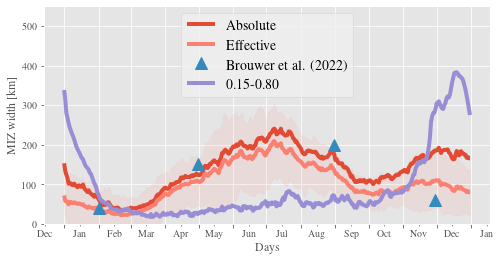

In [20]:
#not any(miz_idx)
Cmap = np.asarray([[0.9805, 0.5000, 0.4453], [0.4416, 0.7490, 0.4322], [0.3639, 0.5755, 0.748]])
    
    
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
x_dates = np.array(unique_dates[day_vec], dtype=np.datetime64)
month_year_formatter = mdates.DateFormatter('%b') # The "," is intentional.

# Plot the MIZ widths
fig, ax = plt.subplots(figsize=(8, 4))

monthly_locator = mdates.MonthLocator()
#ax.xaxis.set_major_locator(half_year_locator)
#ax.xaxis.set_minor_locator(monthly_locator)
#ax.xaxis.set_major_formatter(month_year_formatter)
#ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1))#(1,2,3,4,5,6,7,8,9,10,11,12)))
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

brouwer_dates = [31,31+28+31+30,31+28+31+30+31+30+31+31,31+28+31+30+31+30+31+31+30+31+30]
print(brouwer_dates)

print(mdates.MonthLocator(bymonthday=15))

#plt.style.use("ggplot")
plt.style.use("fivethirtyeight")

line_deviation = 1 * (effective_miz_width_array[day_vec,:].std(axis=1)/1000)
mean = effective_miz_width_array[day_vec,:].mean(axis=1)/1000
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, miz_width_array[day_vec,:].mean(axis=1)/1000, label = "Absolute")
plt.plot(x_dates, mean, label = "Effective", color=Cmap[0,:])
plt.plot(x_dates[brouwer_dates],[40,150,200,60], '^', markersize=12, label = "Brouwer et al. (2022)")
plt.plot(x_dates, sic_width_array[day_vec,:].mean(axis=1)/1000, label = "0.15-0.80")


plt.fill_between(x_dates, lower, upper, color=Cmap[0,:], alpha=.1)


#plt.xticks(range(0, n_days))

plt.xlabel("Days")
plt.ylabel("MIZ width [km]")
plt.legend()
ax.set_ylim([0, 550])
plt.show()

fig.autofmt_xdate()
fig.savefig(savepath+'miz_width.png', dpi = 300) 




NameError: name 'day_vec' is not defined

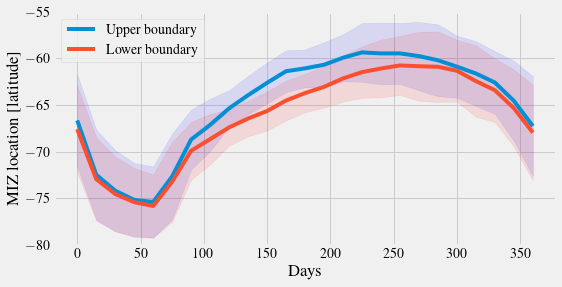

84
154


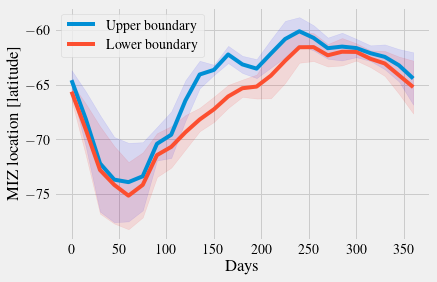

264
354


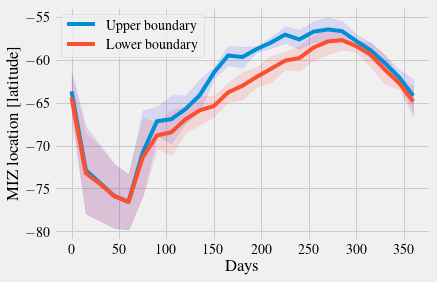

354
84


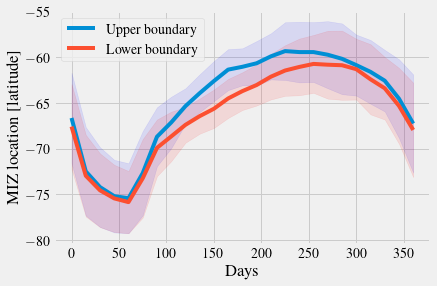

Amundsen Belling
154
219


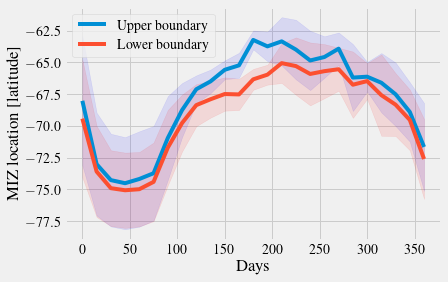

Weddell
219
264


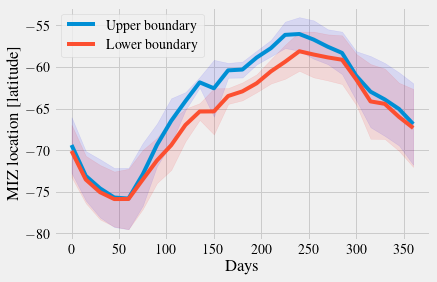

In [175]:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
x_dates = day_vec #np.array(unique_dates[day_vec], dtype=np.datetime64)
#month_year_formatter = mdates.DateFormatter('%b') # The "," is intentional.

# Plot the MIZ widths
fig, ax = plt.subplots(figsize=(8, 4))


#monthly_locator = mdates.MonthLocator()
#ax.xaxis.set_major_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
#ax.xaxis.set_major_formatter(NullFormatter())
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

plt.style.use("fivethirtyeight")

line_deviation = 1 * (miz_upper_boundary[day_vec,:].std(axis=1))
mean = miz_upper_boundary[day_vec,:].mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, miz_upper_boundary[day_vec,:].mean(axis=1), label = "Upper boundary")
plt.fill_between(x_dates, lower, upper, color='b', alpha=.1)

line_deviation = 1 * (miz_lower_boundary[day_vec,:].std(axis=1))
mean = miz_lower_boundary[day_vec,:].mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)
plt.plot(x_dates, miz_lower_boundary[day_vec,:].mean(axis=1), label = "Lower boundary")
plt.fill_between(x_dates, lower, upper, color='r', alpha=.1)

#plt.xticks(range(0, n_days))

plt.xlabel("Days")
plt.ylabel("MIZ location [latitude]")
plt.legend()
ax.set_ylim([-80, -55])
plt.show()

fig.autofmt_xdate()
fig.savefig(savepath+'miz_location.png', dpi = 300) 



# SECTORS
## Ross-Amundsen Sea
sector_min = 165
sector_max = 235
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
line_deviation = 1 * (miz_upper_boundary[day_vec,sector_idx_min:sector_idx_max].std(axis=1))
mean = miz_upper_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, miz_upper_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1), label = "Upper boundary")
plt.fill_between(x_dates, lower, upper, color='b', alpha=.1)

line_deviation = 1 * (miz_lower_boundary[day_vec,sector_idx_min:sector_idx_max].std(axis=1))
mean = miz_lower_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)
plt.plot(x_dates, miz_lower_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1), label = "Lower boundary")
plt.fill_between(x_dates, lower, upper, color='r', alpha=.1)

plt.xlabel("Days")
plt.ylabel("MIZ location [latitude]")
plt.legend()
ax.set_ylim([-80, -55])
plt.show()

fig.autofmt_xdate()
fig.savefig(savepath+'miz_location_Ross-Amundsen.png', dpi = 300) 


## King Hakon VII
sector_min = 345
sector_max = 75
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
line_deviation = 1 * (miz_upper_boundary[day_vec,sector_idx_min:sector_idx_max].std(axis=1))
mean = miz_upper_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, miz_upper_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1), label = "Upper boundary")
plt.fill_between(x_dates, lower, upper, color='b', alpha=.1)

line_deviation = 1 * (miz_lower_boundary[day_vec,sector_idx_min:sector_idx_max].std(axis=1))
mean = miz_lower_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)
plt.plot(x_dates, miz_lower_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1), label = "Lower boundary")
plt.fill_between(x_dates, lower, upper, color='r', alpha=.1)

plt.xlabel("Days")
plt.ylabel("MIZ location [latitude]")
plt.legend()
ax.set_ylim([-80, -55])
plt.show()

fig.autofmt_xdate()
fig.savefig(savepath+'miz_location_King-Hakon-VII.png', dpi = 300) 


## East Antarctica
sector_min = 75
sector_max = 165
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
sector_idx = ((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
sector_idx = sector_idx[0]
line_deviation = 1 * (miz_upper_boundary[day_vec,sector_idx].std(axis=1))
mean = miz_upper_boundary[day_vec,sector_idx].mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, miz_upper_boundary[day_vec,sector_idx].mean(axis=1), label = "Upper boundary")
plt.fill_between(x_dates, lower, upper, color='b', alpha=.1)

line_deviation = 1 * (miz_lower_boundary[day_vec,sector_idx].std(axis=1))
mean = miz_lower_boundary[day_vec,sector_idx].mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)
plt.plot(x_dates, miz_lower_boundary[day_vec,sector_idx].mean(axis=1), label = "Lower boundary")
plt.fill_between(x_dates, lower, upper, color='r', alpha=.1)

plt.xlabel("Days")
plt.ylabel("MIZ location [latitude]")
plt.legend()
ax.set_ylim([-80, -55])
plt.show()

fig.autofmt_xdate()
fig.savefig(savepath+'miz_location_East-Antarctica.png', dpi = 300) 

## Amundsen Belling
print("Amundsen Belling")
sector_min = 235
sector_max = 300
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
#sector_idx = ((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
#sector_idx = sector_idx
line_deviation = 1 * (miz_upper_boundary[day_vec,sector_idx_min:sector_idx_max].std(axis=1))
mean = miz_upper_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, miz_upper_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1), label = "Upper boundary")
plt.fill_between(x_dates, lower, upper, color='b', alpha=.1)

line_deviation = 1 * (miz_lower_boundary[day_vec,sector_idx_min:sector_idx_max].std(axis=1))
mean = miz_lower_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)
plt.plot(x_dates, miz_lower_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1), label = "Lower boundary")
plt.fill_between(x_dates, lower, upper, color='r', alpha=.1)

plt.xlabel("Days")
plt.ylabel("MIZ location [latitude]")
plt.legend()
ax.set_ylim([-80, -55])
plt.show()

fig.autofmt_xdate()
fig.savefig(savepath+'miz_location_Amun-Bellin.png', dpi = 300) 


## Weddell
print("Weddell")
sector_min = 300
sector_max = 345
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
#sector_idx = ((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
#sector_idx = sector_idx
line_deviation = 1 * (miz_upper_boundary[day_vec,sector_idx_min:sector_idx_max].std(axis=1))
mean = miz_upper_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, miz_upper_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1), label = "Upper boundary")
plt.fill_between(x_dates, lower, upper, color='b', alpha=.1)

line_deviation = 1 * (miz_lower_boundary[day_vec,sector_idx_min:sector_idx_max].std(axis=1))
mean = miz_lower_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)
plt.plot(x_dates, miz_lower_boundary[day_vec,sector_idx_min:sector_idx_max].mean(axis=1), label = "Lower boundary")
plt.fill_between(x_dates, lower, upper, color='r', alpha=.1)

plt.xlabel("Days")
plt.ylabel("MIZ location [latitude]")
plt.legend()
ax.set_ylim([-80, -55])
plt.show()

fig.autofmt_xdate()
fig.savefig(savepath+'miz_location_Weddell.png', dpi = 300) 


In [169]:
#print(sector_idx_min)
#print(sector_idx_max)


#print(sector_idx)
#np.asarray(range(sector_idx_min,360), range(1,sector_idx_max))
#print(LN[1,sector_idx_max:-1])
#print(LN[1,0:sector_idx_max])
#np.concatenate(range(sector_idx_max,360), range(1,sector_idx_min))

#print(miz_upper_boundary[day_vec,sector_idx[0]])
#miz_upper_boundary.shape
#sector_idx.shape

sector_idx = np.asarray((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
print(sector_idx)
#sector_idx = sector_idx[0]
#print(sector_idx)
#print(sector_idx)
miz_upper_boundary[day_vec,sector_idx]

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
  True  True  True  True  True  True  True  True  T

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (25,) (65,) 

In [103]:
miz_upper_boundary[day_vec,:].mean(axis=1)
x_dates
LN[1,:]

a = abs(LN[1,:]-60)
i = np.unravel_index(a.argmin(),a.shape)
i
LN[1,i]

array([59.5], dtype=float32)

In [ ]:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
x_dates = range(0,365) #np.array(unique_dates[day_vec], dtype=np.datetime64)
month_year_formatter = mdates.DateFormatter('%b') # The "," is intentional.
diff = effective_miz_width_array[1:-1,:]/1000 - effective_miz_width_array[0:-2,:]/1000


# Plot the MIZ widths
fig, ax = plt.subplots(figsize=(8, 4))

#monthly_locator = mdates.MonthLocator()
#ax.xaxis.set_major_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
#ax.xaxis.set_major_formatter(NullFormatter())
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
#plt.style.use("fivethirtyeight")
plt.plot(x_dates[0:-2], diff.mean(axis=1))

print( diff[:,1].shape)
#plt.plot(x_dates[0:-2], diff[:,range(0,360,200)], alpha=.1)

line_deviation = 1 * (diff.std(axis=1))
mean = diff.mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)
plt.fill_between(x_dates[0:-2], lower, upper, color='r', alpha=.1)
#plt.xlabel("Days")
#plt.ylabel("Change in MIZ width [km]")
#plt.legend()
#ax.set_ylim([0, 550])
plt.show()

fig.autofmt_xdate()
fig.savefig(savepath+'delta_miz_width.png', dpi = 300) 
print(upper)

(300, 360)

In [112]:
#upper = (mean + line_deviation)
#print(upper)
#lower

#df_kmeans['k'] = predicted # kmeans.labels_
effective_miz_width_array.shape
#print(kmeans.cluster_centers_)
#df_kmeans.to_csv('kmeans.csv', index=False)

#ds = xr.open_dataset(onlyfiles[0])
#HTE = ds.HTE.values
#HTN = ds.HTN.values
#tarea = ds.tarea.values
#tmask = ds.tmask.values

filename=f"/scratch/ia40/nd0349/mizWidth_2011.nc"
d_vars = {"effective" : (['time','nj'],effective_miz_width_array,
                              {'long_name' :"Effective width",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "sic" : (['time','nj'],sic_width_array,
                              {'long_name' :"Sea ice concentration width [0.15, 0.8]",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "absolute" : (['time','nj'],miz_width_array,
                          {'long_name':"Absolute width",
                           'units'    :"m",
                           '_FillValue':-2e8})}
          
coords = {"LON"  : (["nj"],LN[1,:],{'units':'degrees_east'}),
          "time" : (["time"],range(1,366))}
attrs = {'creation_date': "2023-04-04",#datetime.now().strftime('%Y-%m-%d %H'),
         'conventions'  : "",
         'title'        : "MIZ width for CICE-WIM standalone 1-degree data",
         'source'       : ", ",
         'comment'      : "",
         'author'       : 'Noah Day',
         'email'        : 'noah.day@adelaide.edu.au'}
enc_dict  = {'shuffle':True,'zlib':True,'complevel':5} 
nc_out = xr.Dataset(data_vars=d_vars,coords=coords,attrs=attrs)
write_job = nc_out.to_netcdf(filename,unlimited_dims=['time'],compute=False)#,encoding={'glbrad':enc_dict})


In [110]:
LN[1,:]

array([ 80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,
        89.5,  90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,
        98.5,  99.5, 100.5, 101.5, 102.5, 103.5, 104.5, 105.5, 106.5,
       107.5, 108.5, 109.5, 110.5, 111.5, 112.5, 113.5, 114.5, 115.5,
       116.5, 117.5, 118.5, 119.5, 120.5, 121.5, 122.5, 123.5, 124.5,
       125.5, 126.5, 127.5, 128.5, 129.5, 130.5, 131.5, 132.5, 133.5,
       134.5, 135.5, 136.5, 137.5, 138.5, 139.5, 140.5, 141.5, 142.5,
       143.5, 144.5, 145.5, 146.5, 147.5, 148.5, 149.5, 150.5, 151.5,
       152.5, 153.5, 154.5, 155.5, 156.5, 157.5, 158.5, 159.5, 160.5,
       161.5, 162.5, 163.5, 164.5, 165.5, 166.5, 167.5, 168.5, 169.5,
       170.5, 171.5, 172.5, 173.5, 174.5, 175.5, 176.5, 177.5, 178.5,
       179.5, 180.5, 181.5, 182.5, 183.5, 184.5, 185.5, 186.5, 187.5,
       188.5, 189.5, 190.5, 191.5, 192.5, 193.5, 194.5, 195.5, 196.5,
       197.5, 198.5, 199.5, 200.5, 201.5, 202.5, 203.5, 204.5, 205.5,
       206.5, 207.5,

TypeError: Dimensions of C (8770, 1) are incompatible with X (8770) and/or Y (8771); see help(pcolormesh)

/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value

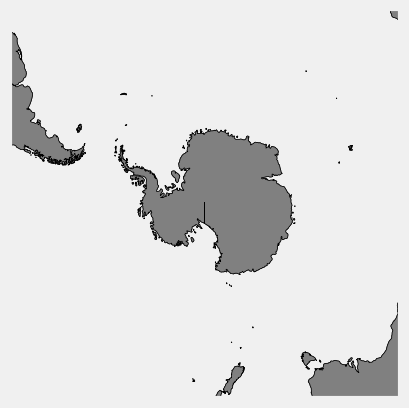

In [53]:
#print(k.shape)

plt.figure()
cmap = cmo.deep
coord_lims = [-180, 180, 90, -90]
ax.set_extent(coord_lims, ccrs.PlateCarree())
ax = plt.subplot(1, 1, 0+1, projection=ccrs.SouthPolarStereo(), label='{0}'.format(counter))
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(lon, lat, k,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)
plt.savefig(savepath+'kmean.png', dpi = 300)  

#k
#filename










len_tmp, = kmeans.labels_.shape
kmean_datavec = kmeans.labels_.reshape((len_tmp,1))

coord_lims = [-180, 180, -40, -90]
ax = plt.subplot(1, 1, 0+1, projection=ccrs.SouthPolarStereo(), label='{0}'.format(counter))
#print('     ' + exp)
#ax= plot_map(ax,exp,ds,LN,LT)
#ax = plt(projection=ccrs.SouthPolarStereo())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
ax.set_extent(coord_lims, ccrs.PlateCarree())
#gl = ax.gridlines(draw_labels=False)
sic_threshold = 0.05 
aice_data = ds['aice'][0,:,:]

plot_data = aice_data #ds[exp][0,:,:]
plot_data = np.ma.masked_where(aice_data < sic_threshold, plot_data)

cmap = cmo.deep
#cmap = cmap.reversed()

#p1 = ax.pcolormesh(LN,LT,plot_data, 
p1 = ax.pcolormesh(df_standard['longitude'],df_standard['latitude'], kmean_datavec,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
               # norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p1, orientation='vertical', fraction=0.046, pad=0.04)
#fontsize = 6
#cb.ax.set_ylabel( ds[exp].attrs["long_name"].partition(' of ')[0] + ' [' +  ds[exp].attrs["units"] + ']' , size=fontsize);
#cb.ax.tick_params(labelsize=fontsize) 


In [ ]:
kmeans.labels_.shape

kmean_datavec.shape